In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time, math

In [13]:
def pose_vector_to_transformation_matrix(pose_vec: np.ndarray) -> np.ndarray:
    """
    Converts a 6x1 pose vector into a 4x4 transformation matrix.
    Args: pose_vec: 6x1 vector representing the pose as [wx, wy, wz, tx, ty, tz]
    Returns:  T: 4x4 transformation matrix
    """
    # 3d rotation
    omega = pose_vec[:3]
    # 3d translation
    t = pose_vec[3:]
    # unit vector indicating the axis of rotation
    theta = np.sqrt((omega**2).sum())
    k = omega / theta
    kx, ky, kz = k
    # cross-product matrix
    K = np.array([[0, -kz, ky],
                  [kz, 0, -kx],
                  [-ky, kx, 0]])
    # Rodrigues' rotation formula
    R = np.eye(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

def distort_points(x: np.ndarray,D: np.ndarray,K: np.ndarray) -> np.ndarray:
    """
    Applies lens distortion to 2D points xon the image plane.
    Args:   x: 2d points (Nx2)
            D: distortion coefficients (4x1)
            K: camera matrix (3x3)
    """
    k1, k2 = D[0], D[1]
    u0 = K[0, 2]
    v0 = K[1, 2]
    xp = x[:, 0] - u0
    yp = x[:, 1] - v0
    r2 = xp**2 + yp**2
    xpp = u0 + xp * (1 + k1*r2 + k2*r2**2)
    ypp = v0 + yp * (1 + k1*r2 + k2*r2**2)
    x_d = np.stack([xpp, ypp], axis=-1)
    return x_d

def project_points(points_3d: np.ndarray, K: np.ndarray, D: np.ndarray) -> np.ndarray:
    """
    Projects 3d points to the image plane, given the camera matrix, and distortion coefficients.
    Args:   points_3d: 3d points (3xN)
            K: camera matrix (3x3)
            D: distortion coefficients (4x1)
    Returns: projected_points: 2d points (2xN)
    """
    # get image coordinates
    projected_points = np.matmul(K, points_3d[:, :, None]).squeeze(-1)
    projected_points /= projected_points[:, 2, None]
    # apply distortion
    projected_points = distort_points(projected_points[:, :2], D, K)
    return projected_points

def undistort_image(img: np.ndarray, K: np.ndarray, D: np.ndarray, bilinear_interpolation: bool = False) -> np.ndarray:
    """
    Corrects an image for lens distortion.
    Args:   img: distorted image (HxW)
            K: camera matrix (3x3)
            D: distortion coefficients (4x1)
            bilinear_interpolation: whether to use bilinear interpolation or not
    """
    height, width = img.shape
    undistorted_img = np.zeros([height, width])

    for x in range(width):
        for y in range(height):
            # apply distortion
            x_d = distort_points(np.array([[x, y]]), D, K)
            u, v = x_d[0, :]
            # bilinear interpolation
            u1 = math.floor(u)
            v1 = math.floor(v)
            if bilinear_interpolation:
                a = u - u1
                b = v - v1
                if (u1 >= 0) & (u1+1 < width) & (v1 >= 0) & (v1+1 < height):
                    undistorted_img[y, x] = (1 - b) * ( (1 - a) * img[v1, u1] + a * img[v1, u1+1]) \
                                            + b * ( (1 - a) * img[v1 + 1, u1] + a * img[v1 + 1, u1 + 1] )
            else:
                if (u1 >= 0) & (u1 < width) & (v1 >= 0) & (v1 < height):
                    undistorted_img[y, x] = img[v1, u1]
    return undistorted_img

def undistort_image_vectorized(img: np.ndarray,
                               K: np.ndarray,
                               D: np.ndarray) -> np.ndarray:
    """
    Undistorts an image using the camera matrix and distortion coefficients.
    Args:   img: distorted image (HxW)
            K: camera matrix (3x3)
         D: distortion coefficients (4x1)
    Returns: und_img: undistorted image (HxW)
    """
    height, width = img.shape[-2:]
    X, Y = np.meshgrid(np.arange(width), np.arange(height))
    px_locs = np.stack([X, Y], axis=-1).reshape([height * width, 2])

    dist_px_locs = distort_points(px_locs, D, K)
    intensity_vals = img[np.round(dist_px_locs[:, 1].astype(int)),
                         np.round(dist_px_locs[:, 0]).astype(int)]
    und_img = intensity_vals.reshape(img.shape).astype(np.uint8)
    return und_img

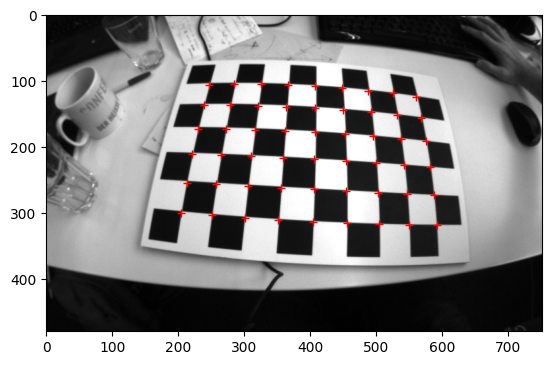

In [14]:
# load camera poses

# each row i of matrix 'poses' contains the transformations that transforms
# points expressed in the world frame to
# points expressed in the camera frame

pose_vectors = np.loadtxt('./data/poses.txt')

# define 3D corner positions
# [Nx3] matrix containing the corners of the checkerboard as 3D points
# (X,Y,Z), expressed in the world coordinate system

square_size = 0.04  # [m]
num_corners_x = 9
num_corners_y = 6
num_corners = num_corners_x * num_corners_y

X, Y = np.meshgrid(np.arange(num_corners_x), np.arange(num_corners_y))
p_W_corners = square_size * np.stack([X, Y], axis=-1).reshape([num_corners, 2])

# add z coordinate, set z=0
p_W_corners = np.concatenate([p_W_corners, np.zeros([num_corners, 1])], axis=-1)

# load camera intrinsics
K = np.loadtxt('./data/K.txt')  # calibration matrix[3x3]
D = np.loadtxt('./data/D.txt')  # distortion coefficients[2x1]

# load one image with a given index
img_index = 1
img = cv2.imread('./data/images/img_{0:04d}.jpg'.format(img_index), cv2.IMREAD_GRAYSCALE)

# project the corners on the image
# compute the 4x4 homogeneous transformation matrix that maps points
# from the world to the camera coordinate frame

T_C_W = pose_vector_to_transformation_matrix(pose_vectors[img_index, :])


# transform 3d points from world to current camera pose
p_C_corners = np.matmul(T_C_W[None, :, :],
                        np.concatenate([p_W_corners,
                                        np.ones([num_corners, 1])],
                                        axis=-1)[:, :, None]).squeeze(-1)
p_C_corners = p_C_corners[:, :3]

projected_pts = project_points(p_C_corners, K, D)
plt.imshow(img, cmap='gray')
plt.plot(projected_pts[:, 0], projected_pts[:, 1], 'r+')
plt.show()



Undistortion with bilinear interpolation completed in 8.688894748687744
Vectorized undistortion completed in 0.03178524971008301


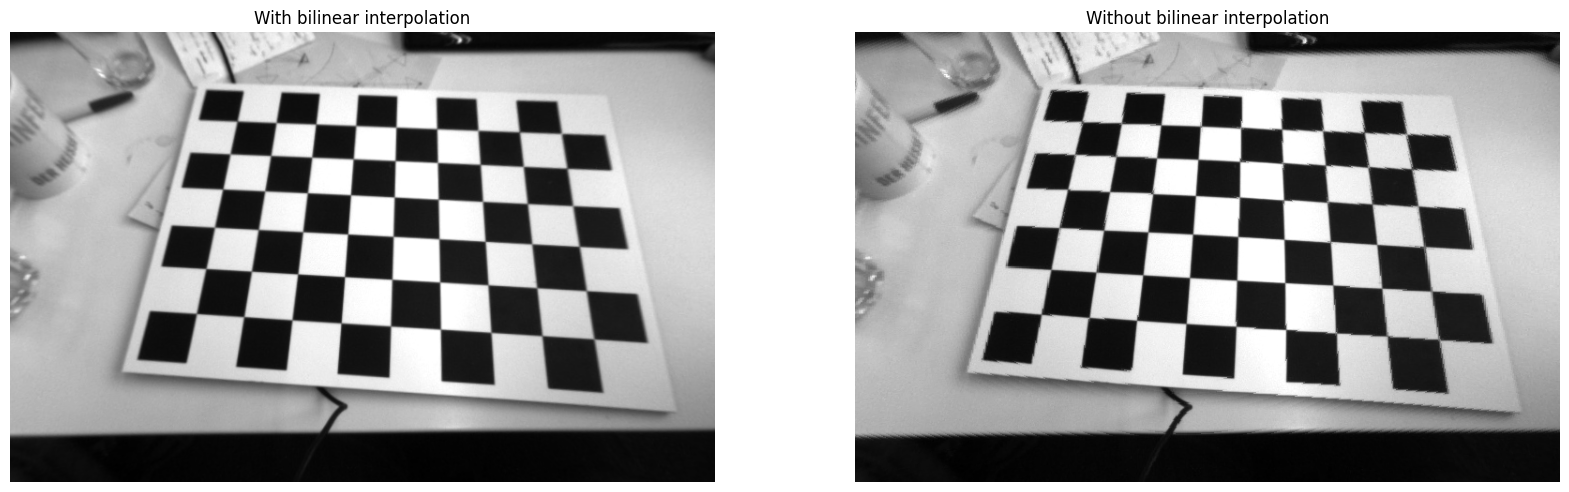

In [16]:
# undistort image with bilinear interpolation
start_t = time.time()
img_undistorted = undistort_image(img, K, D, bilinear_interpolation=True)
print('Undistortion with bilinear interpolation completed in {}'.format(time.time() - start_t))

# vectorized undistortion without bilinear interpolation
start_t = time.time()
img_undistorted_vectorized = undistort_image_vectorized(img, K, D)
print('Vectorized undistortion completed in {}'.format(time.time() - start_t))

plt.clf()
plt.close()
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].imshow(img_undistorted, cmap='gray')
axs[0].set_axis_off()
axs[0].set_title('With bilinear interpolation')
axs[1].imshow(img_undistorted_vectorized, cmap='gray')
axs[1].set_axis_off()
axs[1].set_title('Without bilinear interpolation')
plt.show()


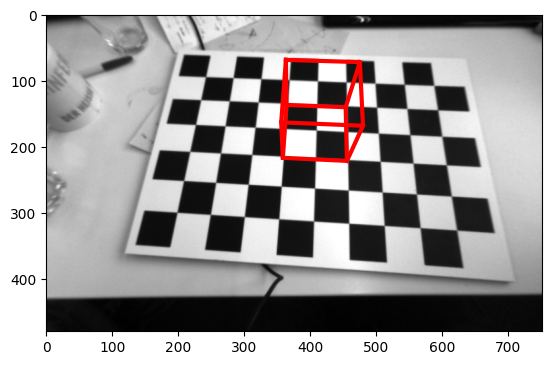

In [17]:
# calculate the cube points to then draw the image
offset_x = 0.04 * 3
offset_y = 0.04
s = 2 * 0.04

X, Y, Z = np.meshgrid(np.arange(2), np.arange(2), np.arange(-1, 1))
p_W_cube = np.stack([offset_x + X.flatten()*s,
                        offset_y + Y.flatten()*s,
                        Z.flatten()*s,
                        np.ones([8])], axis=-1)

p_C_cube = np.matmul(T_C_W[None, :, :], p_W_cube[:, :, None]).squeeze(-1)
p_C_cube = p_C_cube[:, :3]

cube_pts = project_points(p_C_cube, K, np.zeros([4, 1]))

# Plot the cube
plt.clf()
plt.close()
plt.imshow(img_undistorted, cmap='gray')

lw = 3

# base layer of the cube
plt.plot(cube_pts[[1, 3, 7, 5, 1], 0],
            cube_pts[[1, 3, 7, 5, 1], 1],
            'r-',
            linewidth=lw)

# top layer of the cube
plt.plot(cube_pts[[0, 2, 6, 4, 0], 0],
            cube_pts[[0, 2, 6, 4, 0], 1],
            'r-',
            linewidth=lw)

# vertical lines
plt.plot(cube_pts[[0, 1], 0], cube_pts[[0, 1], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[2, 3], 0], cube_pts[[2, 3], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[4, 5], 0], cube_pts[[4, 5], 1], 'r-', linewidth=lw)
plt.plot(cube_pts[[6, 7], 0], cube_pts[[6, 7], 1], 'r-', linewidth=lw)

plt.show()